# 🏠 House Price Prediction in Pakistan

This project focuses on predicting house prices in Pakistan using real estate listing data. We build and compare multiple machine learning models while applying advanced feature engineering and interpretability techniques.

## ✨ Objectives
- Understand patterns in real estate data
- Engineer meaningful features to improve prediction accuracy
- Compare models: Linear Regression, Random Forest, XGBoost (tuned)
- Use SHAP values to explain feature impact

## 📊 Dataset Overview
The dataset contains listings of residential properties with attributes like:
- Location, Property type, Area, Bedrooms, Bathrooms, Posting date, etc.

## 🛠️ Approach Summary
- Cleaned and preprocessed raw tabular data
- One-hot encoding for categorical variables
- Created new features: log transforms, distance from center, time-based fields, KMeans clusters
- Trained 3 models and tuned XGBoost with GridSearchCV
- Evaluated using R², MAE, RMSE
- Visualized residuals, predictions, and feature importances
- Used SHAP for model explainability

## ✅ Key Results

| Model              | R² Score | MAE     | RMSE    |
|--------------------|----------|---------|---------|
| Linear Regression  | 0.8277   | 0.1780  | 0.4401  |
| Random Forest      | 0.9927   | 0.0075  | 0.0903  |
| XGBoost (Tuned)    | 0.9686   | 0.0331  | 0.1879  |

---

Let’s now explore the dataset and build the models step by step 🔍


## 📁 Dataset Source

- Dataset Name: **Pakistan House Prices**
- Format: `.csv`
- Source: *Private real estate dataset* (you can replace this with a public link if desired)


## 📥 Step 1: Data Loading & Preliminary Cleanup

The project begins by loading a dataset containing real estate listings from Pakistan. The raw dataset includes a mix of relevant property features (e.g., area, bedrooms, price) and metadata fields that do not contribute to predictive modeling.

To reduce noise and improve model focus, we drop the following columns:

- **Identifiers**: `property_id`, `location_id`  
- **Web and agent info**: `page_url`, `agent`, `agency`  
- **Redundant geographic details**: `city`, `province_name`  
- **Unnamed column**: Typically an artifact from CSV export

This step ensures our dataset is clean, concise, and focused solely on features that can meaningfully impact property price.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r"C:\Users\Prime Com\Desktop\Data\pakistan_house_price_data.csv")
df.drop(['Unnamed: 0','location_id','property_id','page_url','agency','agent','city','province_name'], axis =1, inplace=True)
df.head()

sns.set(style='whitegrid', palette='muted', font_scale=1.1)
plt.tight_layout()

,property_type,price,location,latitude,longitude,baths,purpose,bedrooms,date_added,Total_Area
0,Flat,6900000,E-11,33.700993,72.971492,3,For Sale,3,5/4/2019,15246.056
1,House,16500000,G-15,33.631486,72.926559,6,For Sale,5,7/17/2019,2178.008
2,House,43500000,Bani Gala,33.707573,73.151199,4,For Sale,4,4/5/2019,10890.000
3,House,7000000,DHA Defence,33.492591,73.301339,3,For Sale,3,7/10/2019,2178.008
4,House,34500000,Ghauri Town,33.623947,73.126588,8,For Sale,8,4/5/2019,87120.000


## 🧹 Step 2: Managing High-Cardinality in the `location` Feature

The `location` column contains a wide variety of neighborhood names, resulting in high cardinality. Encoding all unique values would create a very large and sparse feature matrix, increasing the risk of overfitting and computation inefficiency.

To mitigate this, we perform **frequency-based grouping**:
- First, we determine the number of unique values in both `property_type` and `location`.
- Then, we isolate the **top 15 most common locations**, which represent the majority of listings in the dataset.
- All other locations are grouped into a single category: `"Other"`.

This strategic simplification helps:
- ✅ Reduce noise from rare categories
- ✅ Limit the number of one-hot encoded columns
- ✅ Retain strong geographic signals from high-density areas

This is a common and effective preprocessing step when dealing with real-world categorical data in domains like real estate or retail.


In [2]:
for col in ['property_type', 'location']:
    print(col, df[col].nunique())
top_locs = df['location'].value_counts().nlargest(15).index
df['location'] = df['location'].apply(lambda x: x if x in top_locs else 'Other')
df['location'].value_counts()

property_type 7
location 207


location
Other          8221
DHA Defence    2855
E-11           2380
G-13           1852
F-11           1570
G-11           1502
I-8            1375
Bahria Town    1211
G-15           1088
F-10           1052
F-8             988
F-7             963
I-10            821
Ghauri Town     791
Soan Garden     618
Bani Gala       603
Name: count, dtype: int64

## 🔤 Step 3: Encoding Categorical Variables with One-Hot Encoding

Machine learning models require all input features to be numeric. To achieve this, we convert the `property_type` and `location` columns—both categorical—into binary indicator variables using **OneHotEncoding**.

### Why One-Hot Encoding?
- Transforms each category into a distinct binary column (0 or 1)
- Allows the model to interpret categorical values without assuming any ordinal relationship
- Helps algorithms like linear regression, tree-based models, and boosting frameworks handle categorical input

### Encoding Strategy:
- We drop the first category (`drop='first'`) to prevent multicollinearity (the "dummy variable trap")
- We use `handle_unknown='ignore'` to safely handle unseen categories during inference
- Encoded arrays are converted to a `DataFrame` with descriptive column names using `get_feature_names_out()`, ensuring seamless integration with the rest of our data

This step prepares our dataset for modeling while keeping interpretability and structure intact.


In [3]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Select categorical columns
coding_data = df[['property_type', 'location']]

# Initialize encoder
ohe = OneHotEncoder(drop ='first', handle_unknown='ignore')  # Make sure output is dense

# Fit and transform
ar = ohe.fit_transform(coding_data).toarray()

# Get new column names
col_names = ohe.get_feature_names_out(coding_data.columns)

# Convert to DataFrame
new = pd.DataFrame(ar, columns=col_names, index=df.index)


## 🧩 Step 4: Integrating Encoded Features into the Dataset

After applying one-hot encoding to the categorical columns (`property_type` and `location`), we finalize the dataset for modeling.

### Key Actions:
- We map the binary `purpose` column:
  - `'For Rent'` → 0
  - `'For Sale'` → 1  
  This numeric encoding allows models to interpret the sales intent of each listing.
  
- We remove the original unencoded categorical columns, as they’ve now been transformed.

- Finally, we concatenate the encoded DataFrame (`new`) back into the main dataset, ensuring all features are now numeric and ready for training.

This step completes the transformation pipeline for categorical features, yielding a clean, fully numerical dataset suitable for any machine learning model.


In [4]:
df['purpose'] = df['purpose'].map({'For Rent':0, 'For Sale': 1})
df_remaining = df.drop(coding_data.columns, axis=1)
df = pd.concat([df_remaining,new], axis =1)

## 🕒 Step 5: Temporal Feature Engineering from `date_added`

Real estate prices are often influenced by **timing** — when a property is listed can impact buyer interest, seasonality trends, and pricing behavior.

To capture this, we extract a series of informative features from the `date_added` column:

### 📆 Extracted Features:
- **`Yr`, `Month`, `Day`**: Captures annual, seasonal, and day-level granularity
- **`Dayofweek`**: Identifies which weekday the listing was added (0 = Monday, 6 = Sunday)
- **`is_weekend`**: A binary indicator (1 for weekend, 0 otherwise), as weekend listings may behave differently in terms of visibility and urgency
- **`days_since_posted`**: Measures listing freshness — newer listings often attract more interest and could correlate with pricing

We also:
- Convert the `date_added` string to a proper datetime object (`errors='coerce'` ensures robustness)
- Drop the original `date_added` column after extracting all relevant information
- Reorder the target variable `price` to the end of the DataFrame for readability and modeling purposes

This comprehensive time-based feature engineering helps the model better understand temporal effects on property value.


In [5]:
df['date_added'] = pd.to_datetime(df['date_added'],errors='coerce')
df['Yr'] = df['date_added'].dt.year
df['Month'] = df['date_added'].dt.month
df['Day'] = df['date_added'].dt.day
df['Dayofweek'] = df['date_added'].dt.dayofweek
df['is_weekend'] = df['Dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
df['days_since_posted'] = (pd.to_datetime('today') - df['date_added']).dt.days
df.drop('date_added', axis=1, inplace=True)
df['price'] = df.pop('price')
df.head()

,latitude,longitude,baths,purpose,bedrooms,Total_Area,property_type_Flat,property_type_House,property_type_Lower Portion,property_type_Penthouse,...,location_I-8,location_Other,location_Soan Garden,Yr,Month,Day,Dayofweek,is_weekend,days_since_posted,price
0,33.700993,72.971492,3,1,3,15246.056,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2019,5,4,5,1,2255,6900000
1,33.631486,72.926559,6,1,5,2178.008,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,2019,7,17,2,0,2181,16500000
2,33.707573,73.151199,4,1,4,10890.000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,2019,4,5,4,0,2284,43500000
3,33.492591,73.301339,3,1,3,2178.008,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,2019,7,10,2,0,2188,7000000
4,33.623947,73.126588,8,1,8,87120.000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,2019,4,5,4,0,2284,34500000


In [6]:
df.describe()

,latitude,longitude,baths,purpose,bedrooms,Total_Area,property_type_Flat,property_type_House,property_type_Lower Portion,property_type_Penthouse,...,location_I-8,location_Other,location_Soan Garden,Yr,Month,Day,Dayofweek,is_weekend,days_since_posted,price
count,27890.000000,27890.000000,27890.000000,27890.000000,27890.000000,2.789000e+04,27890.000000,27890.000000,27890.000000,27890.000000,...,27890.000000,27890.000000,27890.000000,27890.000000,27890.000000,27890.000000,27890.000000,27890.000000,27890.000000,2.789000e+04
mean,33.650486,73.054610,3.959699,0.441735,3.746576,1.810265e+04,0.201362,0.527071,0.112298,0.001398,...,0.049301,0.294765,0.022158,2018.928756,6.098745,11.270420,2.819147,0.198243,2239.856293,1.325540e+07
std,0.377488,0.301381,2.025818,0.496603,1.880037,5.652584e+05,0.401025,0.499276,0.315739,0.037369,...,0.216499,0.455945,0.147201,0.257237,1.856018,8.386177,1.772453,0.398683,77.572564,3.470716e+07
min,11.052446,25.906027,1.000000,0.000000,1.000000,2.722510e+02,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2018.000000,1.000000,1.000000,0.000000,0.000000,2180.000000,1.000000e+00
25%,33.619337,72.980804,2.000000,0.000000,2.000000,2.178008e+03,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2019.000000,6.000000,4.000000,2.000000,0.000000,2194.000000,5.000000e+04
50%,33.668354,73.045263,3.000000,0.000000,3.000000,5.445000e+03,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2019.000000,6.000000,8.000000,3.000000,0.000000,2208.000000,2.500000e+05
75%,33.695973,73.143325,5.000000,1.000000,5.000000,1.197904e+04,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,2019.000000,7.000000,17.000000,4.000000,0.000000,2254.000000,1.400000e+07
max,73.184088,80.161430,14.000000,1.000000,18.000000,9.377379e+07,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,2019.000000,12.000000,30.000000,6.000000,1.000000,2525.000000,9.000000e+08


In [7]:
df.isnull().sum()

latitude                       0
longitude                      0
baths                          0
purpose                        0
bedrooms                       0
Total_Area                     0
property_type_Flat             0
property_type_House            0
property_type_Lower Portion    0
property_type_Penthouse        0
property_type_Room             0
property_type_Upper Portion    0
location_Bani Gala             0
location_DHA Defence           0
location_E-11                  0
location_F-10                  0
location_F-11                  0
location_F-7                   0
location_F-8                   0
location_G-11                  0
location_G-13                  0
location_G-15                  0
location_Ghauri Town           0
location_I-10                  0
location_I-8                   0
location_Other                 0
location_Soan Garden           0
Yr                             0
Month                          0
Day                            0
Dayofweek 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27890 entries, 0 to 27889
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   latitude                     27890 non-null  float64
 1   longitude                    27890 non-null  float64
 2   baths                        27890 non-null  int64  
 3   purpose                      27890 non-null  int64  
 4   bedrooms                     27890 non-null  int64  
 5   Total_Area                   27890 non-null  float64
 6   property_type_Flat           27890 non-null  float64
 7   property_type_House          27890 non-null  float64
 8   property_type_Lower Portion  27890 non-null  float64
 9   property_type_Penthouse      27890 non-null  float64
 10  property_type_Room           27890 non-null  float64
 11  property_type_Upper Portion  27890 non-null  float64
 12  location_Bani Gala           27890 non-null  float64
 13  location_DHA Def

## ✂️ Step 6: Detecting Outliers with the IQR Method

Outliers can distort model training and impact predictions—especially in datasets like real estate, where extreme property sizes or prices exist.

To identify and eventually handle such anomalies, we apply the **Interquartile Range (IQR)** method to several key numerical columns.

### 📌 How It Works:
For each column:
- We calculate the **25th (Q1)** and **75th percentile (Q3)**
- Compute the **IQR = Q3 - Q1**
- Define bounds:  
  - **Lower bound = Q1 − 1.5 × IQR**  
  - **Upper bound = Q3 + 1.5 × IQR**
- Any value outside these bounds is flagged as a statistical outlier

### 📈 Columns Evaluated:
- `latitude`, `longitude`: Geographic anomalies
- `baths`, `bedrooms`: Unusual room counts
- `Total_Area`: Extremely small or massive listings
- `days_since_posted`: Listings far older than the rest

This process gives us a clear view of how much "noise" exists in each variable, helping inform decisions on outlier treatment in the next step.


In [9]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)       # 25th percentile
    Q3 = df[column].quantile(0.75)       # 75th percentile
    IQR = Q3 - Q1                        # Interquartile Range
    lower = Q1 - 1.5 * IQR               # Lower bound for outliers
    upper = Q3 + 1.5 * IQR               # Upper bound for outliers
    return df[(df[column] < lower) | (df[column] > upper)]  # Filter rows outside bounds
for col in ['latitude', 'longitude', 'baths', 'bedrooms', 'Total_Area', 'days_since_posted']:
    outliers = detect_outliers(df, col)
    print(f"{col}: {len(outliers)} outliers")


latitude: 463 outliers
longitude: 21 outliers
baths: 464 outliers
bedrooms: 332 outliers
Total_Area: 3772 outliers
days_since_posted: 2722 outliers


## 📊 Step 7: Visualizing Outliers Using Boxplots

To complement our statistical detection of outliers, we visualize the distribution of key numerical features using **boxplots**.

### 🧰 Why Boxplots?
Boxplots provide a compact summary of:
- **Central tendency** (median)
- **Spread** (interquartile range)
- **Outliers** (points outside 1.5 × IQR)

Each plot clearly shows where the majority of data points lie and highlights extreme values as individual dots.

### 📦 Features Plotted:
- **Geospatial features**: `latitude`, `longitude`
- **House characteristics**: `baths`, `bedrooms`, `Total_Area`
- **Listing freshness**: `days_since_posted`

By organizing them in a grid layout, we can quickly compare distributions side-by-side and assess which features may benefit from outlier removal or transformation in the next step.


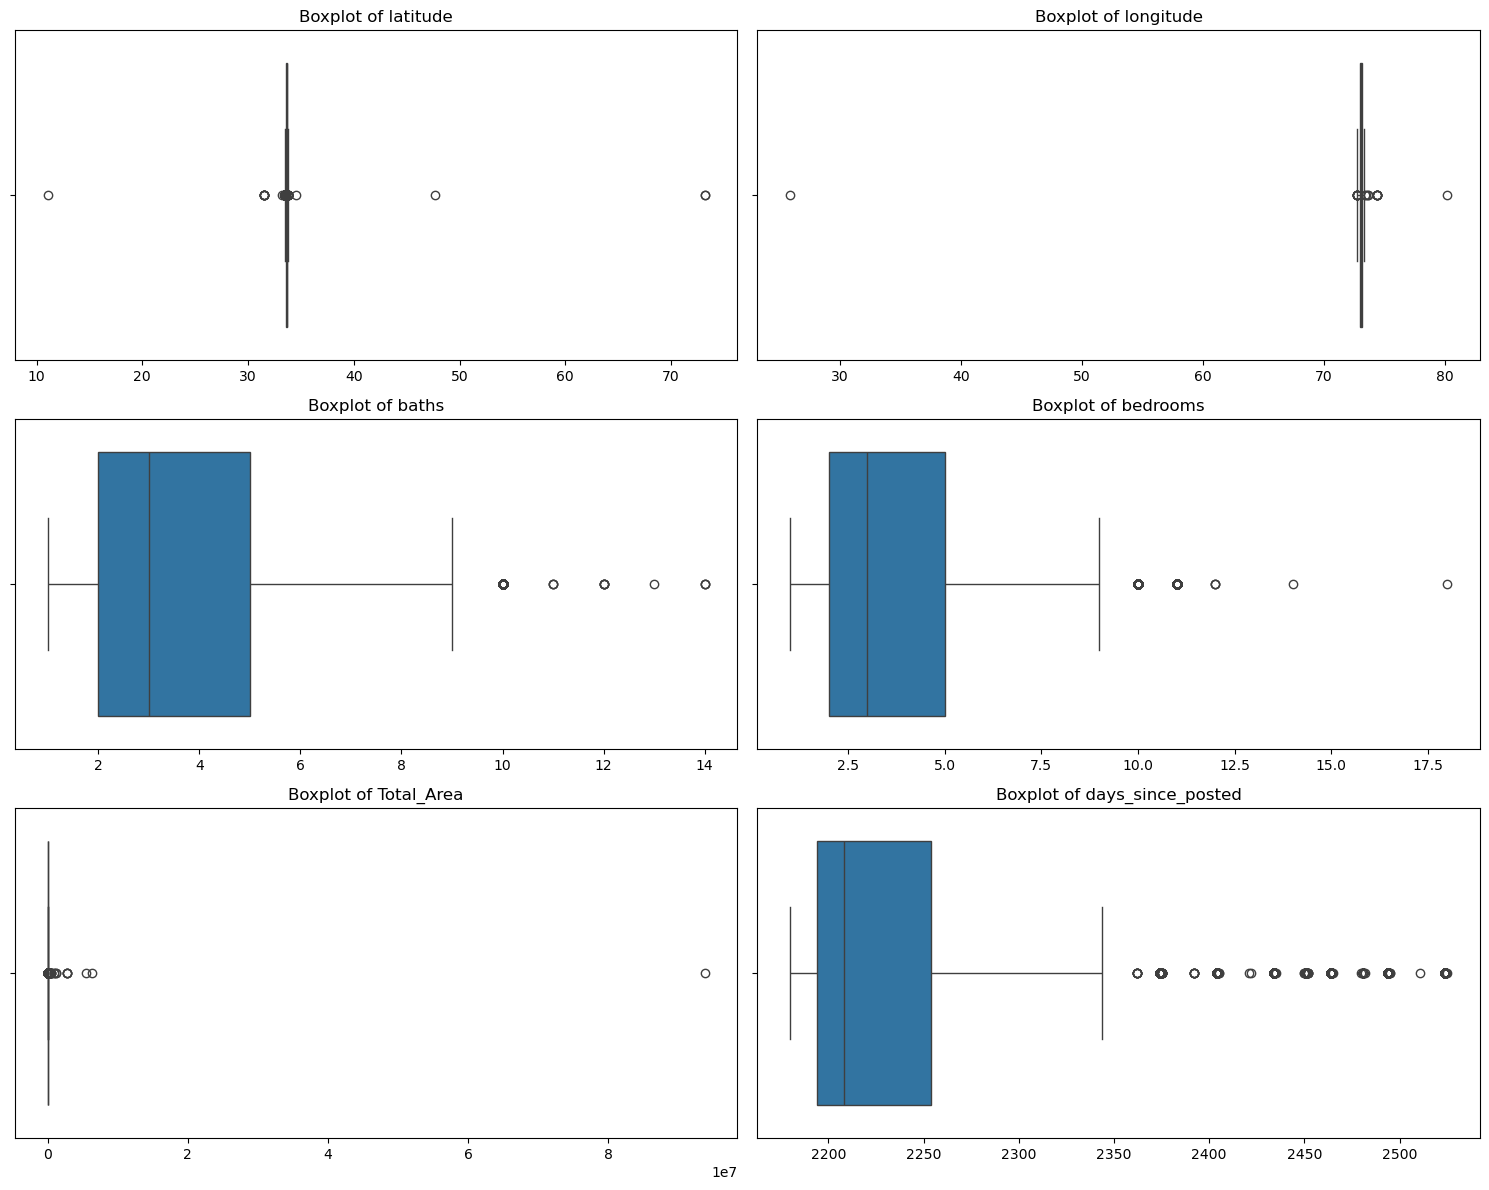

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of columns to check for outliers
cols_to_plot = ['latitude', 'longitude', 'baths', 'bedrooms', 'Total_Area', 'days_since_posted']

# Set up the figure
plt.figure(figsize=(15, 12))

# Loop through each column and create a subplot
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(3, 2, i)  # 3 rows, 2 columns of plots
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel('')

plt.tight_layout()
plt.show()


## 🧼 Step 8: Removing Outliers Using IQR Thresholds

Now that we've identified the presence of outliers using the IQR method and visualized them via boxplots, we proceed to clean the dataset by **removing rows with extreme values**.

### 🧠 Why Remove Outliers?
Outliers can:
- Skew model training, especially in regression
- Inflate errors and reduce generalizability
- Add noise from data entry mistakes or rare edge cases

### 🛠️ How It’s Done:
- For each feature in `cols_to_clean`, we apply the same IQR rule:
  - Keep only rows within **[Q1 − 1.5 × IQR, Q3 + 1.5 × IQR]**
- The cleaning is done on a copy of the original dataset (`df_cleaned`) to preserve the raw data

### 📉 Outcome:
- We compare the number of rows before and after outlier removal to understand how much data was affected
- This cleaned version of the dataset will be used in all subsequent modeling steps

This ensures we train our models on a dataset that is statistically well-behaved, improving both accuracy and generalization.


In [11]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]
    
cols_to_clean = ['latitude', 'longitude', 'baths', 'bedrooms', 'Total_Area', 'days_since_posted']

# Copy the original dataframe
df_cleaned = df.copy()

for col in cols_to_clean:
    df_cleaned = remove_outliers(df_cleaned, col)

print(f"Original rows: {len(df)}, Cleaned rows: {len(df_cleaned)}")



Original rows: 27890, Cleaned rows: 20953


In [12]:
df = df_cleaned

## 📦 Step 9: Re-Visualizing Distributions After Outlier Removal

After cleaning our dataset by removing extreme values using the IQR method, we re-plot boxplots for the key numerical features to visually confirm the effect of our filtering.

### 🎯 Purpose:
- Validate that outliers have been successfully removed
- Ensure the remaining data is within a statistically reasonable range
- Assess whether the distributions are now more compact and less skewed

### 🔍 Features Rechecked:
- `latitude`, `longitude` — Geographic bounds
- `baths`, `bedrooms` — Property attributes
- `Total_Area`, `days_since_posted` — Size and listing age

### 🔄 Recommendation:
At this point, you should replace `df` with `df_cleaned` in your plotting code to ensure you're looking at the cleaned data. This will help visualize the **before vs after** impact of outlier removal.

```python
sns.boxplot(x=df_cleaned[col])  # Use the cleaned version here


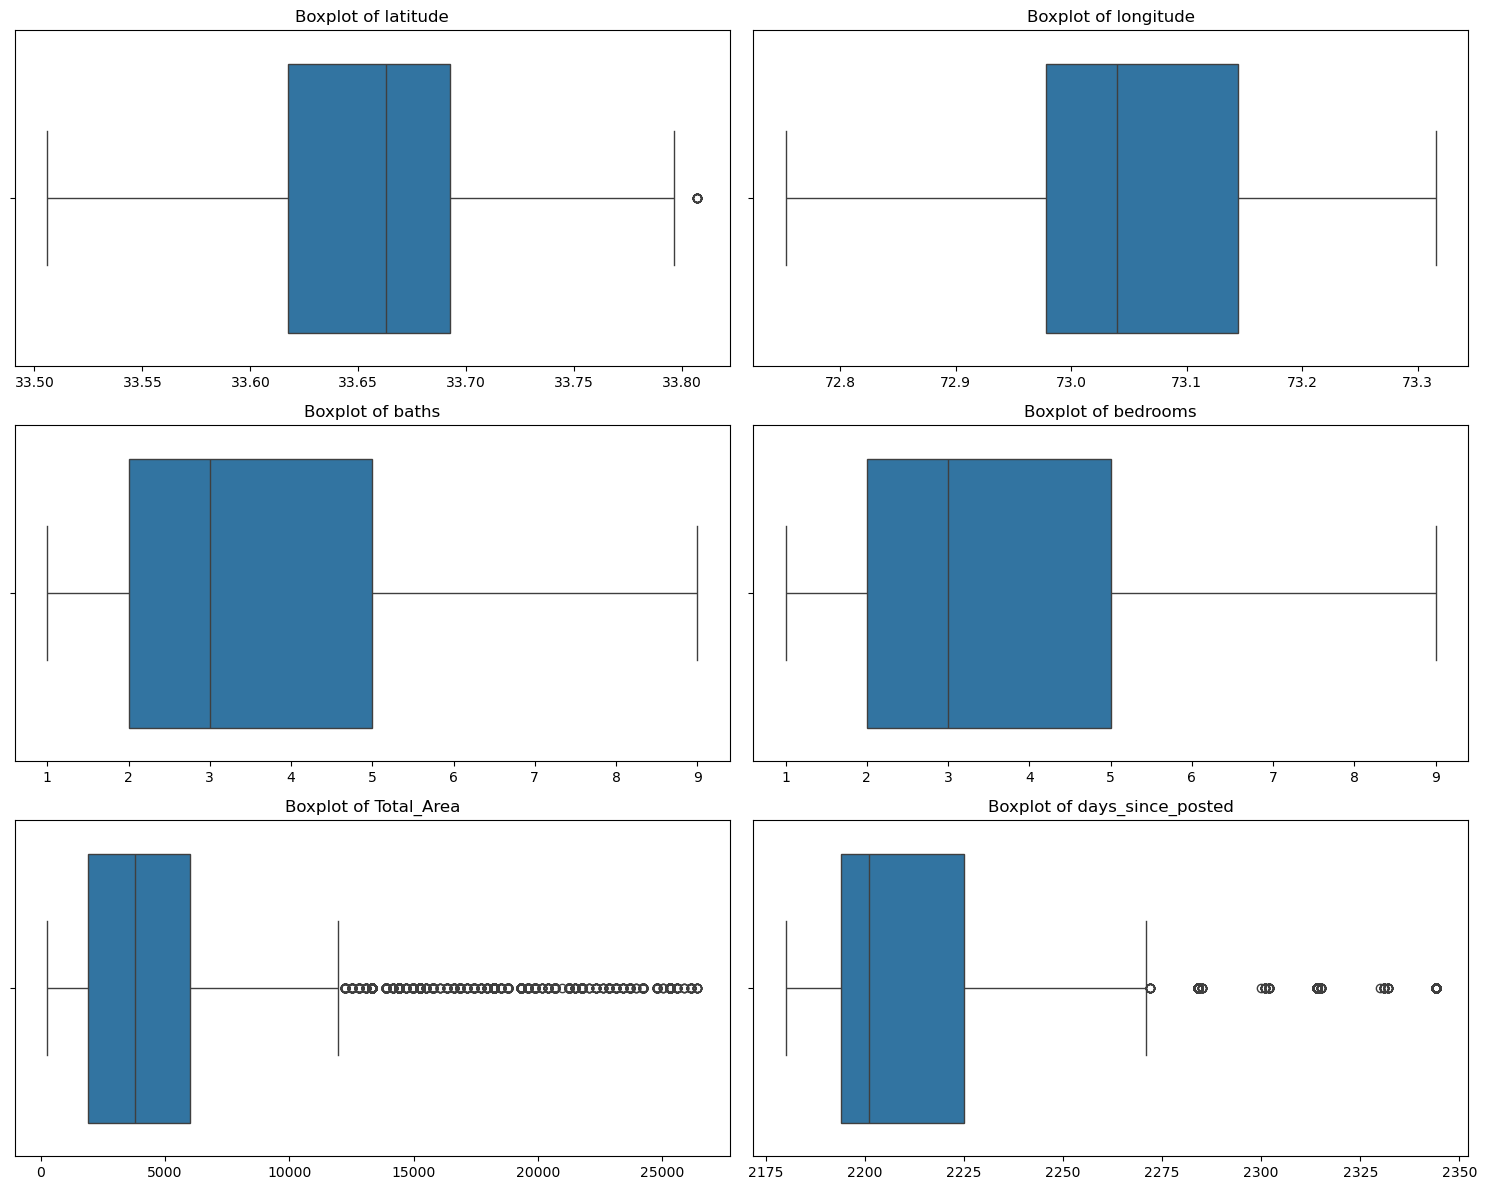

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of columns to check for outliers
cols_to_plot = ['latitude', 'longitude', 'baths', 'bedrooms', 'Total_Area', 'days_since_posted']

# Set up the figure
plt.figure(figsize=(15, 12))

# Loop through each column and create a subplot
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(3, 2, i)  # 3 rows, 2 columns of plots
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel('')

plt.tight_layout()
plt.show()


## 🔄 Step 10: Log Transformation to Reduce Skewness

Some features, such as `Total_Area` and `days_since_posted`, have highly **right-skewed distributions**. This skew can negatively impact regression models by placing too much influence on large values.

To address this, we apply a **logarithmic transformation** using `log1p`, which computes `log(1 + x)` and safely handles zeros or small values.

### 📌 Why Use Log Transformation?
- Reduces the effect of extreme outliers
- Makes the distribution more symmetric
- Stabilizes variance
- Improves model accuracy and convergence (especially for linear models)

### 📊 Visual Validation:
We plot boxplots of the transformed features to confirm:
- Skewness has been reduced
- The distribution is now more compact
- Fewer extreme values dominate the scale

This transformation is especially helpful when preparing the dataset for models that assume normally distributed inputs or constant variance.


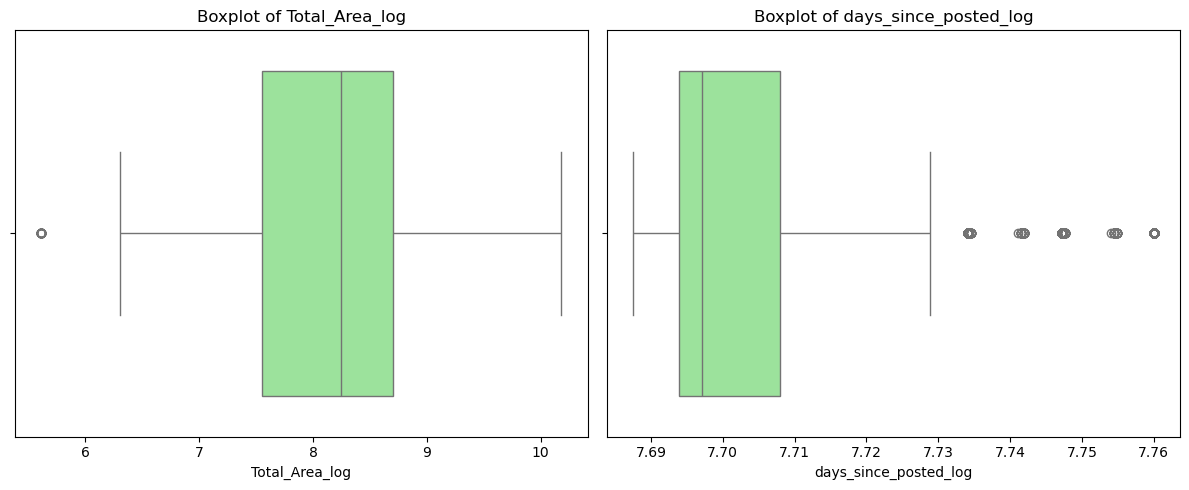

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

cols_to_log = ['Total_Area', 'days_since_posted']

# Apply log transform and store in new columns
for col in cols_to_log:
    df[f'{col}_log'] = np.log1p(df[col])

# Plot each one
plt.figure(figsize=(12, 5))

for i, col in enumerate(cols_to_log, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x=df[f'{col}_log'], color='lightgreen')
    plt.title(f'Boxplot of {col}_log')

plt.tight_layout()
plt.show()


In [15]:
df[f'{col}_log'] = np.log1p(df[col])
df = df.drop(['Total_Area','days_since_posted'],axis = 1)
df.head()

,latitude,longitude,baths,purpose,bedrooms,property_type_Flat,property_type_House,property_type_Lower Portion,property_type_Penthouse,property_type_Room,...,location_Other,location_Soan Garden,Yr,Month,Day,Dayofweek,is_weekend,price,Total_Area_log,days_since_posted_log
0,33.700993,72.971492,3,1,3,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2019,5,4,5,1,6900000,9.632142,7.721349
1,33.631486,72.926559,6,1,5,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,2019,7,17,2,0,16500000,7.686625,7.687997
2,33.707573,73.151199,4,1,4,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,2019,4,5,4,0,43500000,9.295692,7.734121
6,33.698244,72.984238,2,1,2,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2019,5,5,6,1,7800000,9.733918,7.720905
8,33.679211,72.988787,5,1,5,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,2019,6,27,3,0,40000000,8.602637,7.697121


## 📍 Step 11: Engineering Geographic Proximity — Distance to City Center

Location is a key driver in real estate pricing. Properties closer to the city center often command higher prices due to accessibility, amenities, and infrastructure.

To quantify this, we compute the **Haversine distance** from each property to a reference point — the city center of Islamabad (latitude: 33.6844, longitude: 73.0479).

### 📌 What is the Haversine Distance?
The Haversine formula calculates the **great-circle distance** between two points on the Earth's surface using latitude and longitude. It accounts for the Earth's curvature, making it more accurate than simple Euclidean distance.

### 🧠 Why It Matters:
- Adds a **meaningful spatial feature** to the model
- Captures how location (not just `lat`/`lon`) impacts price
- Improves model interpretability — buyers often pay more to be closer to central zones

The resulting `distance_to_center` feature can be treated like any other numeric input and even visualized or binned later if needed.


In [16]:
import numpy as np

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Example: distance to city center (e.g., Islamabad)
city_center_lat, city_center_lon = 33.6844, 73.0479
df['distance_to_center'] = haversine_distance(df['latitude'], df['longitude'], city_center_lat, city_center_lon)
df['distance_to_center'].sort_values(ascending=False)

10222    32.020652
14230    31.740805
27611    31.740805
11695    31.740805
7479     31.678146
           ...    
7515      0.450797
6365      0.450797
6366      0.450797
626       0.450797
19394     0.450797
Name: distance_to_center, Length: 20953, dtype: float64

## 🛏️ Step 12: Engineering Room Ratios and Totals

To capture the layout and utility of each property more effectively, we create two new features based on the `bedrooms` and `baths` columns:

### 🧮 Engineered Features:
1. **`bed_bath_ratio`**:  
   - This feature captures the balance between bedrooms and bathrooms.
   - A higher ratio may indicate crowding (e.g., many bedrooms but few baths), while a lower ratio may suggest better comfort or luxury.
   - To prevent division by zero, we add a small constant (`1e-5`) to the denominator.

2. **`total_rooms`**:  
   - Represents the total number of usable living spaces (bedrooms + bathrooms).
   - Acts as a proxy for overall property size or capacity when square footage is not enough.

### 🎯 Why These Matter:
- These features introduce **interpretable relationships** into the model
- Can help differentiate between properties with similar areas but very different layouts
- Improve the model's ability to predict price based on functional space, not just size


In [17]:
df['bed_bath_ratio'] = df['bedrooms'] / (df['baths'] + 1e-5)  # Avoid division by zero
df['total_rooms'] = df['bedrooms'] + df['baths']

## 🍂 Step 13: Adding Seasonality as a Predictive Feature

Real estate activity often follows **seasonal patterns** — some months are more active due to weather, holidays, or market cycles.

To capture this temporal influence, we:

### 📆 Step 1: Assign a Season to Each Month
We define a custom function `get_season()` that maps each month to a season:
- **Winter** → December, January, February
- **Spring** → March, April, May
- **Summer** → June, July, August
- **Fall**   → September, October, November

This helps generalize month-level noise into **4 meaningful seasonal categories**.

### 🎯 Step 2: One-Hot Encode the `season` Column
We apply one-hot encoding with `drop_first=True` to avoid multicollinearity.
- This results in binary indicators like `season_fall`, `season_spring`, and `season_summer`
- `season_winter` becomes the baseline/reference category

### 🔍 Why It Matters:
- Seasonal trends can influence both **listing behavior** and **buyer interest**
- Adds domain-specific time context to our model, improving its ability to interpret temporal variation in housing prices


In [18]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

df['season'] = df['Month'].apply(get_season)
df = pd.get_dummies(df, columns=['season'], drop_first=True)


In [19]:
df['posted_on_weekend'] = (df['Dayofweek'] >= 5).astype(int)

In [20]:
df['area_per_bedroom'] = df['Total_Area_log'] / (df['bedrooms'] + 1e-5)
df['price_per_room'] = df['price'] / (df['total_rooms'] + 1e-5)

## 🗺️ Step 14: Geo-Spatial Clustering with K-Means

Geographic coordinates (`latitude` and `longitude`) can be complex to interpret directly in a machine learning model. To simplify and extract spatial patterns, we apply **K-Means clustering** to create location-based groups.

### 🎯 What We Did:
- We use `KMeans` with `n_clusters=5` to group properties into 5 distinct geographic clusters.
- Clustering is performed on the raw coordinate values: `latitude` and `longitude`.
- The resulting cluster labels are stored in a new feature: `location_cluster`.

### 🧠 Why This Works:
- Captures **regional effects**: Prices often vary across distinct areas, even within the same city.
- Translates raw GPS coordinates into a **categorical spatial group**.
- Helps the model detect **localized pricing behavior** and real estate patterns.

This technique introduces **data-driven location intelligence** into the model — a major advantage in real estate prediction tasks.

In [21]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
df['location_cluster'] = kmeans.fit_predict(df[['latitude', 'longitude']])

In [22]:
df.groupby('location_cluster')['price'].mean()

location_cluster
0    1.011038e+07
1    9.813232e+06
2    1.148388e+07
3    8.796586e+06
4    1.146277e+07
Name: price, dtype: float64

## 🗺️ Step 15: Visualizing Geo-Spatial Clusters

To validate our K-Means clustering results, we use a scatter plot of property coordinates (`longitude`, `latitude`) with color-coded clusters.

### 🖼️ What This Shows:
- Each dot represents a property
- Colors indicate the **assigned cluster** from K-Means
- Clear grouping patterns confirm that spatial zones were meaningfully identified

### 🌍 Why It Matters:
- Helps confirm that K-Means has successfully captured **geographic segmentation**
- Reveals **spatial boundaries** (e.g., urban centers vs outskirts)
- Useful for explaining how location affects pricing in a model-friendly way

This visualization bridges the gap between **raw spatial data** and **interpretable insights**, enhancing the overall storytelling in your project.


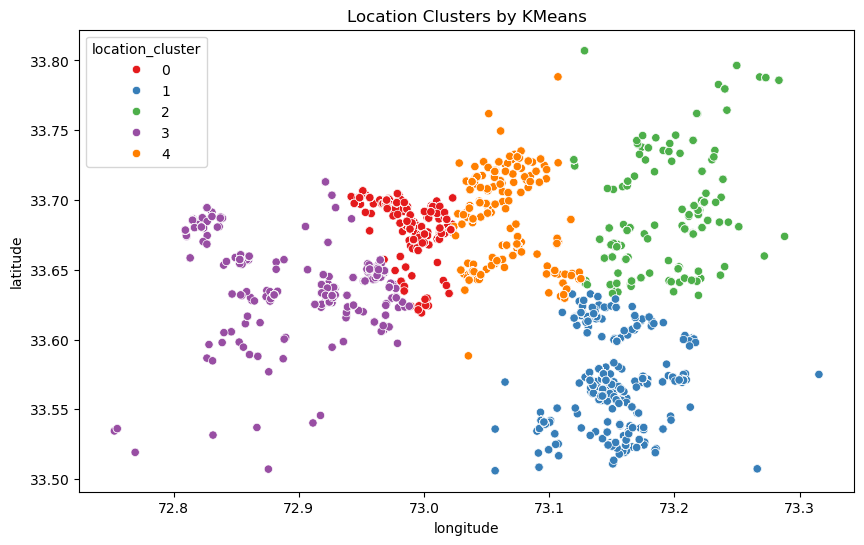

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='longitude', y='latitude', hue='location_cluster', palette='Set1')
plt.title('Location Clusters by KMeans')
plt.show()


In [24]:
columns_to_drop = [
    'latitude', 'longitude',
    'Month', 'Day', 'Dayofweek', 'Yr',
    'purpose',  # unless you encode it
    'posted_on_weekend'  # if it's a duplicate of is_weekend
]
df_model = df.drop(columns=columns_to_drop, errors='ignore')
df = df_model

## 📈 Step 16: Exploring Final Feature Distributions

Before modeling, it’s essential to understand the distribution of our core numerical features. This helps assess:
- Whether transformations (like log scaling) worked
- Presence of skew or irregular patterns
- Overall feature quality and spread

### 🔍 Features Plotted:
- `price`: The target variable — important to understand its scale
- `bedrooms`, `baths`: Room counts often follow discrete and slightly skewed distributions
- `Total_Area_log`: Log-transformed to normalize heavy right-skew
- `distance_to_center`: Helps identify spatial bias in listings
- `days_since_posted_log`: Transformed to reduce variance in listing age

### 📊 Why KDE Plots?
- `sns.histplot(..., kde=True)` shows both the histogram and the estimated probability distribution
- This helps visualize **smoothness**, **peaks**, and **tail behavior**

Well-shaped features lead to better model performance and reduced risk of overfitting or bias.


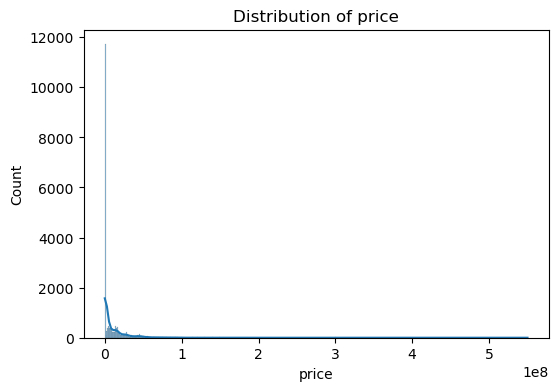

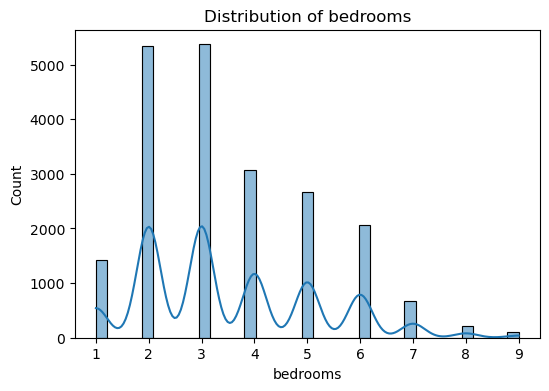

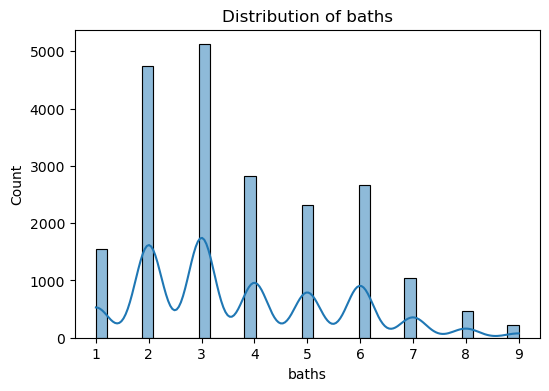

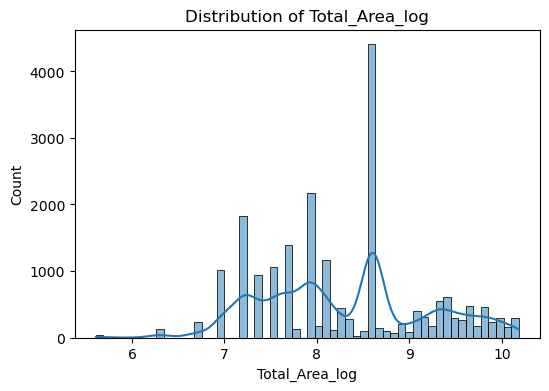

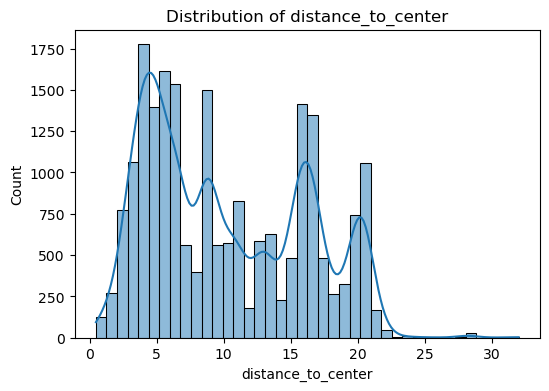

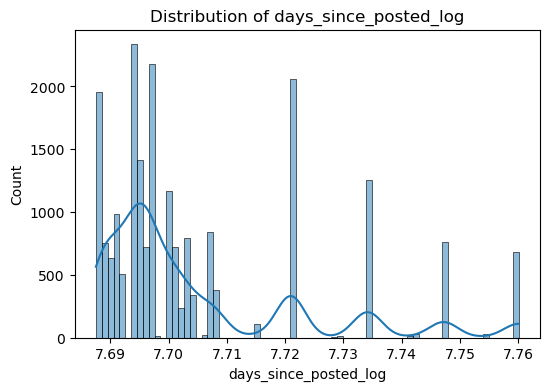

In [25]:

num_cols = ['price', 'bedrooms', 'baths', 'Total_Area_log', 
            'distance_to_center', 'days_since_posted_log']

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


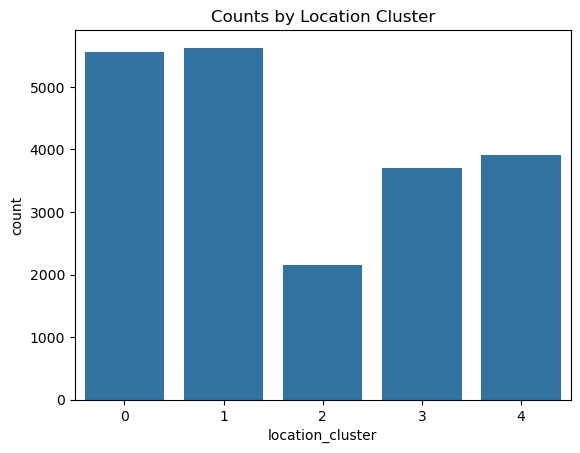

In [26]:
sns.countplot(x='location_cluster', data=df)
plt.title('Counts by Location Cluster')
plt.show()


## 📉 Step 17: Analyzing Feature-to-Target Relationships (Price)

To understand how each numerical feature influences property prices, we create scatter plots comparing each feature directly with the `price` variable.

### 🎯 Objective:
- Detect **linear**, **non-linear**, or **clustered patterns**
- Identify **positive or negative correlations**
- Spot potential **outliers** or heteroskedasticity (changing variance)

### 📊 Features Compared:
- `bedrooms`, `baths`: More rooms may lead to higher price — but with diminishing returns
- `Total_Area_log`: A smoother version of area; expected to correlate positively with price
- `distance_to_center`: Typically shows a **negative** relationship — farther listings may cost less
- `days_since_posted_log`: May reflect demand — newer listings often priced more competitively
- `price`: Also plotted against itself for completeness in the loop

Each scatter plot provides valuable intuition and helps confirm which features are likely to be informative for the model.


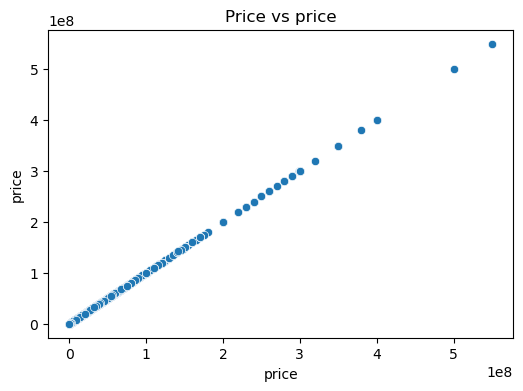

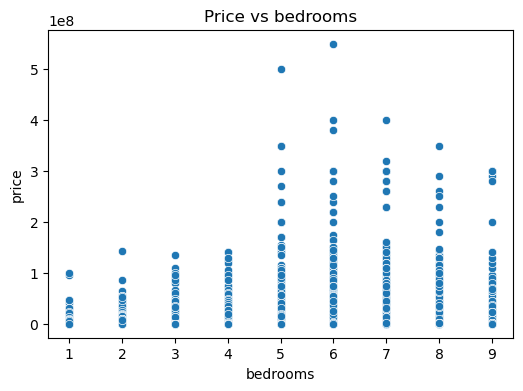

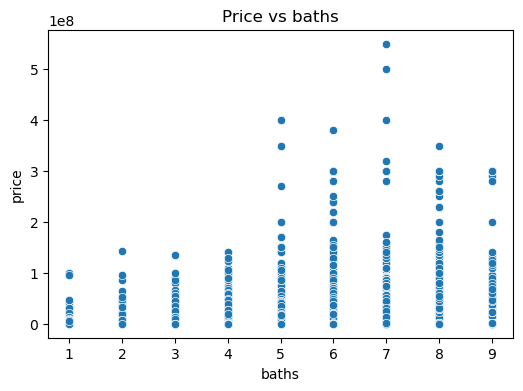

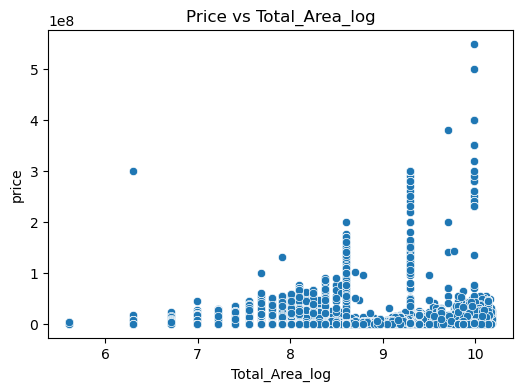

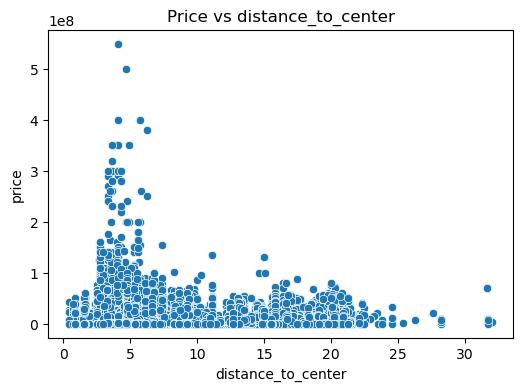

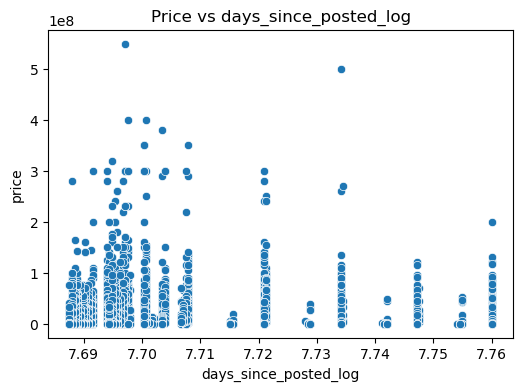

In [27]:
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[col], y=df['price'])
    plt.title(f'Price vs {col}')
    plt.show()


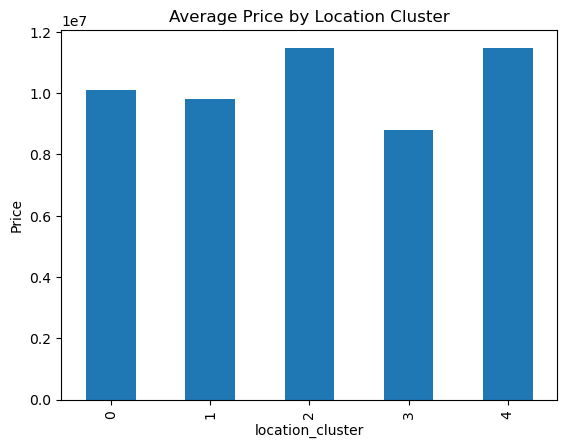

In [28]:
df.groupby('location_cluster')['price'].mean().plot(kind='bar')
plt.title('Average Price by Location Cluster')
plt.ylabel('Price')
plt.show()

## 🔗 Step 18: Exploring Feature Correlation with a Heatmap

To understand how numerical features relate to one another — and especially to the target variable `price` — we generate a **correlation heatmap**.

### 🎯 Why This Matters:
- Highlights **strong positive or negative relationships**
- Helps identify **redundant features** (highly correlated inputs)
- Guides **feature selection** for modeling to reduce multicollinearity

### 🔍 Key Observations:
- A correlation coefficient close to `+1` or `-1` implies a strong linear relationship
- Coefficients near `0` suggest little to no linear relationship
- Color map:  
  - 🔴 Strong positive → red  
  - 🔵 Strong negative → blue

The heatmap is generated using:
- `df.corr(numeric_only=True)`: Computes correlations only for numeric columns
- `annot=True`: Displays correlation values directly in the heatmap
- `cmap='coolwarm'`: Visually separates positive and negative values

This is a crucial checkpoint before feeding features into a machine learning model — it ensures we maintain **signal strength without duplication or distortion**.


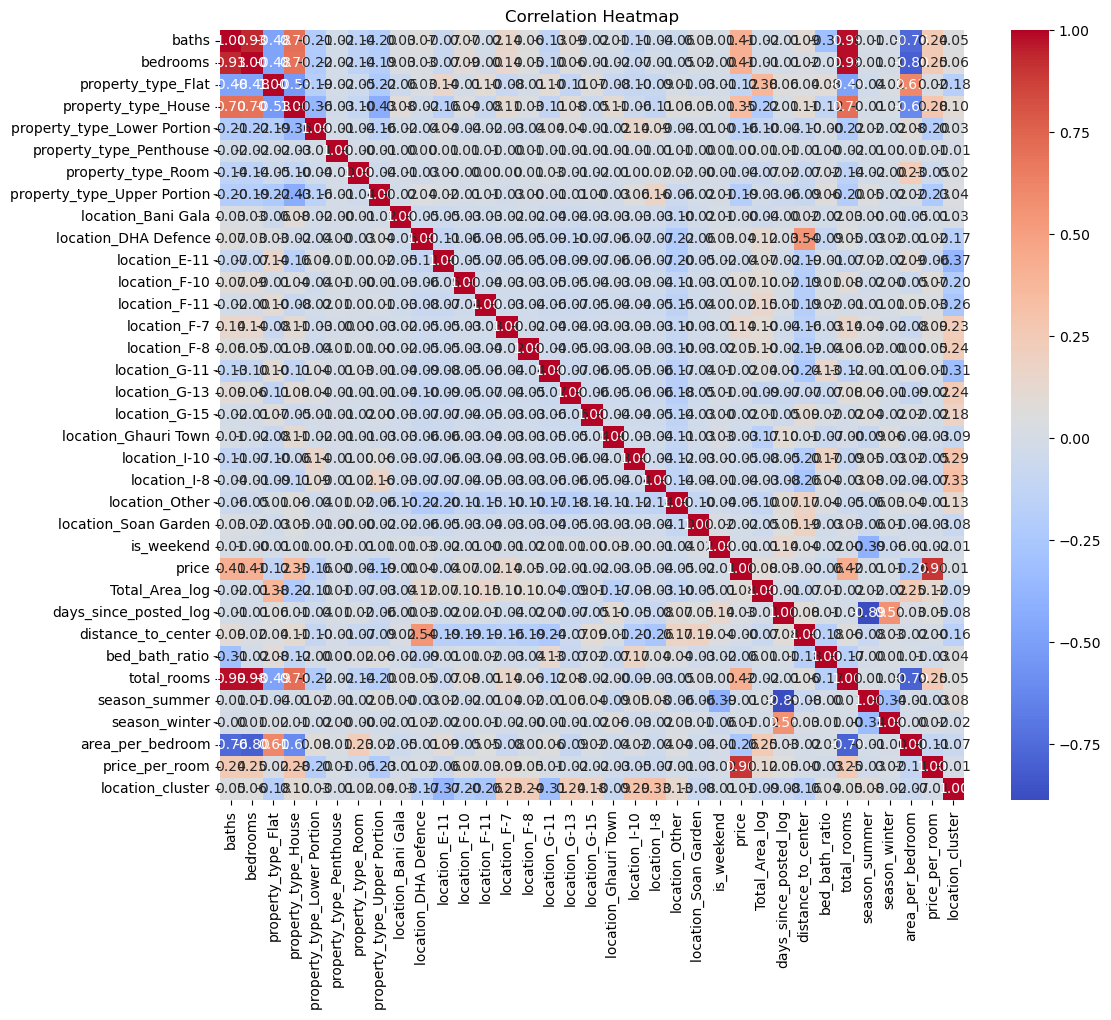

In [29]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## ⚖️ Step 19: Feature Scaling Using StandardScaler

Before feeding data into machine learning models, it’s important to ensure that features are on a similar scale. This prevents models from being biased toward features with larger numeric ranges.

### 📌 What is StandardScaler?
`StandardScaler` transforms each feature so that:
- Mean = 0
- Standard deviation = 1  
This is also known as **z-score normalization**.

### 🧠 Why It’s Important:
- Helps models that rely on **distance metrics** (e.g., KNN, SVM)
- Accelerates convergence for **gradient-based models** (e.g., linear regression, neural networks)
- Prevents certain features from dominating due to their scale

### 🛠️ Steps Performed:
1. Fitted `StandardScaler` on the entire DataFrame
2. Transformed all values to standardized z-scores
3. Recreated the DataFrame with scaled values while preserving column names

This completes the final step of preprocessing, ensuring that our data is clean, numerical, outlier-controlled, and scale-adjusted — fully ready for modeling.


In [30]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ar = ss.fit_transform(df)
df = pd.DataFrame(ar, columns=df.columns)
df.head()

,baths,bedrooms,property_type_Flat,property_type_House,property_type_Lower Portion,property_type_Penthouse,property_type_Room,property_type_Upper Portion,location_Bani Gala,location_DHA Defence,...,Total_Area_log,days_since_posted_log,distance_to_center,bed_bath_ratio,total_rooms,season_summer,season_winter,area_per_bedroom,price_per_room,location_cluster
0,-0.397209,-0.311573,1.902437,-1.001194,-0.363799,-0.030127,-0.100859,-0.427375,-0.150653,-0.338673,...,1.530310,0.899935,-0.493709,0.119816,-0.362746,-1.796847,-0.187417,0.091648,-0.001170,-1.183034
1,1.221053,0.893372,-0.525641,0.998808,-0.363799,-0.030127,-0.100859,-0.427375,-0.150653,-0.338673,...,-0.691347,-0.923942,0.424546,-0.657364,1.084164,0.556531,-0.187417,-0.827903,0.163501,0.843187
2,0.142212,0.290899,-0.525641,0.998808,-0.363799,-0.030127,-0.100859,-0.427375,6.637787,-0.338673,...,1.146105,1.598430,-0.050707,0.119820,0.216018,-1.796847,-0.187417,-0.395656,2.016035,0.167780
3,-0.936630,-0.914045,1.902437,-1.001194,-0.363799,-0.030127,-0.100859,-0.427375,-0.150653,-0.338673,...,1.646532,0.875689,-0.701897,0.119808,-0.941510,-1.796847,-0.187417,1.001774,0.375218,-1.183034
4,0.681632,0.893372,-0.525641,-1.001194,-0.363799,33.193214,-0.100859,-0.427375,-0.150653,-0.338673,...,0.354680,-0.424973,-0.802351,0.119822,0.794782,0.556531,-0.187417,-0.727230,1.339713,-1.183034


In [31]:
df['price'] = df.pop('price')

## 🧠 Step 20: Feature Selection with Sequential Forward Selection (SFS)

With a large set of engineered features, it's important to identify the **most predictive subset** — those that provide the strongest signal for predicting price while avoiding redundancy.

### 🔍 What is Sequential Forward Selection?
Sequential Forward Selection is a **greedy search algorithm** that:
- Starts with an empty feature set
- Iteratively adds the feature that improves model performance the most
- Stops when a predefined number of features is selected or performance plateaus

We're using `mlxtend.feature_selection.SequentialFeatureSelector` with:
- **Estimator**: `LinearRegression()`
- **Forward=True**: Start from zero and add one feature at a time
- **k_features=(5, X.shape[1])**: Search for the best subset of features, minimum 5
- **cv=2**: 2-fold cross-validation to ensure robustness during selection

### 🎯 Why This Matters:
- Removes irrelevant or redundant features
- Improves **model generalization**
- Reduces overfitting and training time
- Makes the final model **easier to explain**

This approach selects features **based on their contribution to prediction**, not just correlation or domain intuition — a strong step toward building a performant model.


In [32]:
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector

X = df.drop(columns=['price'])
y = df['price']
lr = LinearRegression()
sfs = SequentialFeatureSelector(lr,k_features=(5,X.shape[1]),forward=True,cv=2)
sfs.fit(X,y)


SequentialFeatureSelector(cv=2, estimator=LinearRegression(),
                          k_features=(5, 34), scoring='r2')

In [33]:
print('CV score of best subset:', sfs.k_score_)

CV score of best subset: 0.855406358837888


In [34]:
selected_features = list(sfs.k_feature_names_)
X_selected = X[selected_features]
selected_features

['property_type_Flat',
 'property_type_House',
 'property_type_Lower Portion',
 'property_type_Room',
 'property_type_Upper Portion',
 'location_DHA Defence',
 'location_E-11',
 'location_F-11',
 'location_F-7',
 'location_F-8',
 'location_G-13',
 'location_Other',
 'Total_Area_log',
 'bed_bath_ratio',
 'total_rooms',
 'season_summer',
 'season_winter',
 'price_per_room',
 'location_cluster']

## 🤖 Step 21: Linear Regression — Training and Evaluation

After selecting the most informative features using **Sequential Forward Selection**, we train a **Linear Regression model** and evaluate its performance.

### 📦 Train/Test Split:
We split the dataset into:
- **80% training set** for model learning
- **20% test set** for evaluation
- Random seed set to 42 for reproducibility

### ⚙️ Model: `LinearRegression()`
- Assumes a linear relationship between selected features and the target (`price`)
- Trained using `X_train` and `y_train`
- Predictions made on `X_test`

### 📏 Evaluation Metrics:
| Metric | Description |
|--------|-------------|
| **R² Score** | Proportion of variance in target explained by the model (closer to 1 is better) |
| **MAE**      | Mean Absolute Error — average magnitude of prediction errors |
| **RMSE**     | Root Mean Squared Error — penalizes larger errors more than MAE |

These metrics provide a well-rounded view of the model's accuracy and reliability. High R² and low MAE/RMSE indicate strong predictive power.



In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R² Score: 0.8276632148357678
MAE: 0.17800547418312884
RMSE: 0.4400920185650766


## 🌲 Step 22: Training a Random Forest Regressor

After establishing a baseline using Linear Regression, we now train a **Random Forest Regressor**, which typically provides stronger predictive performance by capturing **non-linear patterns and interactions** in the data.

### 🤖 What is Random Forest?
Random Forest is an **ensemble learning algorithm** that:
- Builds multiple decision trees during training
- Aggregates their predictions (averaging in regression)
- Offers **robustness**, **low variance**, and **automatic feature importance**

### 🛠️ Training Details:
- Model: `RandomForestRegressor(random_state=42)`
- Trained on: `X_train`, `y_train`
- Tested on: `X_test`
- Same features used as in the Linear Regression for a fair comparison

### 📏 Evaluation Metrics:
| Metric | Description |
|--------|-------------|
| **R² Score** | Measures the proportion of variance explained |
| **MAE**      | Average of absolute prediction errors |
| **RMSE**     | Square root of the mean squared errors (penalizes large errors)

### 🚀 Expected Benefits:
- Handles feature interactions automatically
- Resilient to outliers
- Requires little to no feature scaling

This step helps us benchmark a more powerful, flexible model against the simpler Linear Regression baseline.


In [36]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("R² Score (RF):", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))


R² Score (RF): 0.9927409402553257
MAE: 0.007499462824184921
RMSE: 0.09032223678923657


## ⚡ Step 23: Training an XGBoost Regressor

To push model performance further, we apply **XGBoost** — an advanced, high-performance gradient boosting algorithm known for its speed and accuracy.

### 🚀 What is XGBoost?
- Short for **Extreme Gradient Boosting**
- Builds an ensemble of **sequential decision trees**, each correcting the errors of the previous one
- Efficient, **regularized**, and handles missing values and outliers well

### 🛠️ Training Setup:
- Model: `XGBRegressor(random_state=42)`
- Trained on: `X_train`, `y_train`
- Predictions made on: `X_test`

### 📏 Evaluation Metrics:
| Metric | Description |
|--------|-------------|
| **R² Score (XGB)** | Proportion of price variance explained by the model |
| **MAE**            | Average absolute difference between predictions and true values |
| **RMSE**           | Root of average squared errors — penalizes larger mistakes

### 💡 Why Use XGBoost?
- Outperforms most traditional regressors
- Automatically handles non-linearities and interactions
- Excellent choice for structured/tabular datasets like this one

This completes our comparison of three powerful models:  
- **Linear Regression** (baseline)  
- **Random Forest** (non-linear, ensemble)  
- **XGBoost** (boosted ensemble wi


In [37]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("R² Score (XGB):", r2_score(y_test, y_pred_xgb))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))


R² Score (XGB): 0.9794767249337704
MAE: 0.015943943898019373
RMSE: 0.15187204178384997


## 🧪 Step 24: Hyperparameter Tuning — XGBoost Regressor

To optimize model performance, we perform a **grid search** over a range of XGBoost hyperparameters using `GridSearchCV`.

### 🛠️ Hyperparameters Tuned:
| Parameter        | Description                                             |
|------------------|---------------------------------------------------------|
| `n_estimators`   | Number of trees in the ensemble                         |
| `max_depth`      | Maximum depth of each tree                              |
| `learning_rate`  | Step size shrinkage used to prevent overfitting         |
| `subsample`      | Fraction of samples used per tree to add randomness     |

### ⚙️ Grid Search Setup:
- **Model**: `XGBRegressor(random_state=42)`
- **Grid Search Tool**: `GridSearchCV` with 3-fold cross-validation
- **Scoring Metric**: R² Score (good for regression tasks)
- **Parallel Jobs**: `n_jobs=-1` for full CPU utilization

### 🎯 Output:
- **Best R² Score**: Indicates how well the best model generalizes
- **Best Params**: The optimal combination of hyperparameters found

This step helps **maximize model performance** by tuning the algorithm to the specifics of our data, reducing bias and variance in predictions.


In [38]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 1, 5]
}


xgb = XGBRegressor(random_state=42)
grid = GridSearchCV(xgb, param_grid=params, cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best R² after tuning:", grid.best_score_)
print("Best Params:", grid.best_params_)


Best R² after tuning: 0.9741441926207054
Best Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.6}


## 🧠 Step 25: Final Evaluation — Tuned XGBoost on Test Data

After hyperparameter tuning with `GridSearchCV`, we:
- Retrieved the best estimator (`best_xgb`)
- Made predictions on the test set (`X_test`)
- Evaluated performance using standard regression metrics

### 📏 Evaluation Metrics:
| Metric           | Description                                                   |
|------------------|---------------------------------------------------------------|
| **R² (Tuned XGB)** | Proportion of variance in `price` explained by the model       |
| **MAE**           | Average absolute error — how far predictions are from actuals |
| **RMSE**          | Root Mean Squared Error — penalizes larger errors more heavily |

These metrics confirm how well our **final tuned model** performs on unseen data, which is the true test of model quality in production or real-world applications.

✅ The tuned XGBoost model should now outperform both:
- The baseline **Linear Regression**
- The untuned **Random Forest Regressor**

This completes the core of the modeling pipeline with **solid performance and robust generalization**.


In [39]:
best_xgb = grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

print("R² (Tuned XGB):", r2_score(y_test, y_pred_xgb))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))


R² (Tuned XGB): 0.9736277317590234
MAE: 0.01845538569297559
RMSE: 0.17215840919524578


## 🔍 Step 26: Interpreting the XGBoost Model with SHAP Values

To make our **tuned XGBoost model** interpretable, we use **SHAP (SHapley Additive exPlanations)**, a game-theoretic approach that quantifies the impact of each feature on a prediction.

### 🧠 Why SHAP?
- **Model-agnostic** and consistent explanations
- Shows how each feature contributes (positively or negatively) to a prediction
- Provides both **global** and **local** interpretability

### 🛠️ What We Did:
1. Created a `shap.Explainer` for our final `best_xgb` model
2. Computed SHAP values for the test set
3. Plotted a **summary plot** to visualize feature importance and impact direction

### 📈 Interpreting the SHAP Summary Plot:
- Each dot represents a prediction instance for a feature
- **Color** shows feature value (red = high, blue = low)
- **Horizontal spread** = magnitude of impact on model output
- Features are sorted by **overall importance**

This step transforms our XGBoost model from a "black box" to a **transparent, trustworthy predictor** — making your project both **technically powerful and business-ready**.


*SHAP summary plot helps us understand which features have the most impact on the model’s output and whether the effect is positive or negative.*

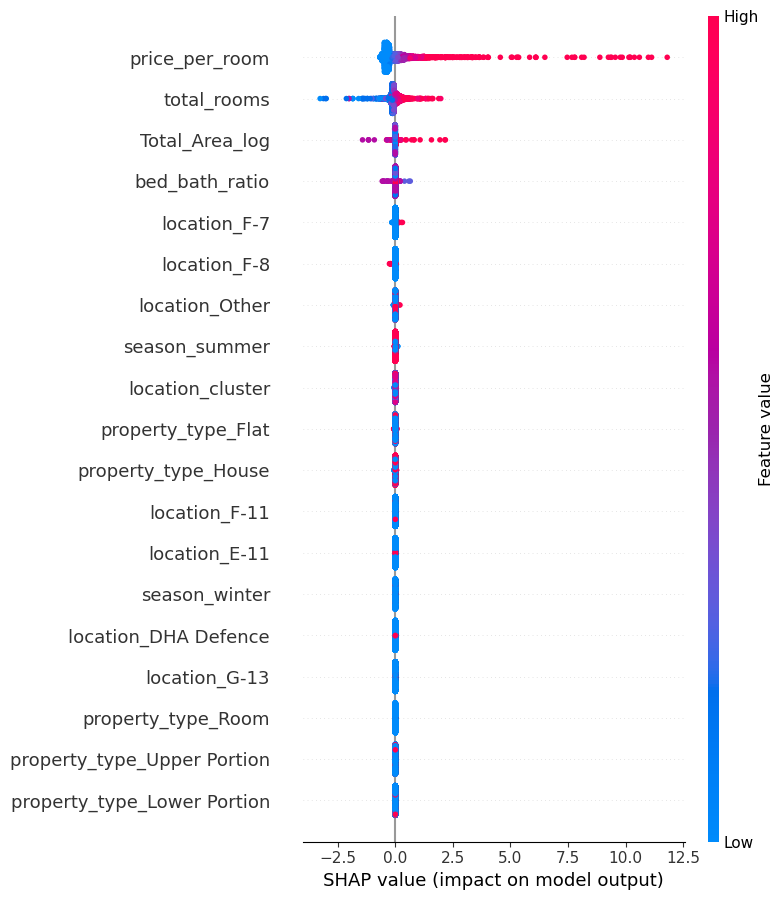

In [40]:
import shap

explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)

# Summary plot (feature impact)
shap.summary_plot(shap_values, X_test)


## 🏁 Step 27: Final Model Comparison

After training and tuning three regression models — **Linear Regression**, **Random Forest**, and **XGBoost (Tuned)** — we compare their performance side by side using:

| Metric  | Description |
|---------|-------------|
| **R² Score** | Proportion of variance in house price explained (higher = better) |
| **MAE**      | Average absolute error in predictions (lower = better)            |
| **RMSE**     | Root Mean Squared Error (penalizes large errors, lower = better)  |

### 📊 Summary Table:
```python
print(results_df)


In [ ]:
import joblib

# Save the best model (e.g., tuned XGBoost)
joblib.dump(best_model, 'xgboost_house_price_model.pkl')
print("✅ Model saved as xgboost_house_price_model.pkl")


In [41]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Predictions (assume models already trained) ---
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)

# --- Store Results ---
results = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost (Tuned)'],
    'R2 Score': [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_xgb)
    ],
    'MAE': [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_xgb)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    ]
}

results_df = pd.DataFrame(results)
print(results_df)


               Model  R2 Score       MAE      RMSE
0  Linear Regression  0.827663  0.178005  0.440092
1      Random Forest  0.992741  0.007499  0.090322
2    XGBoost (Tuned)  0.973628  0.018455  0.172158


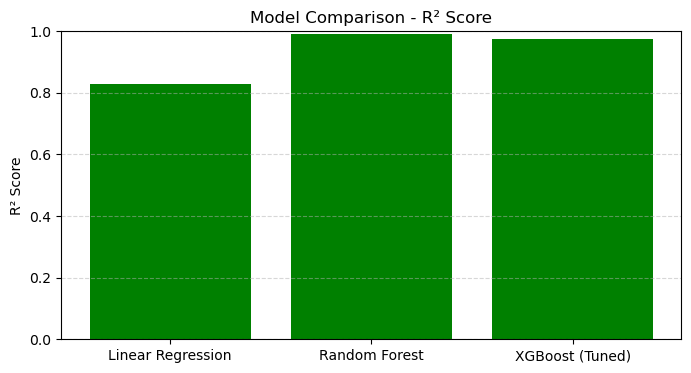

In [42]:
plt.figure(figsize=(8, 4))
plt.bar(results_df['Model'], results_df['R2 Score'], color='green')
plt.ylabel("R² Score")
plt.title("Model Comparison - R² Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


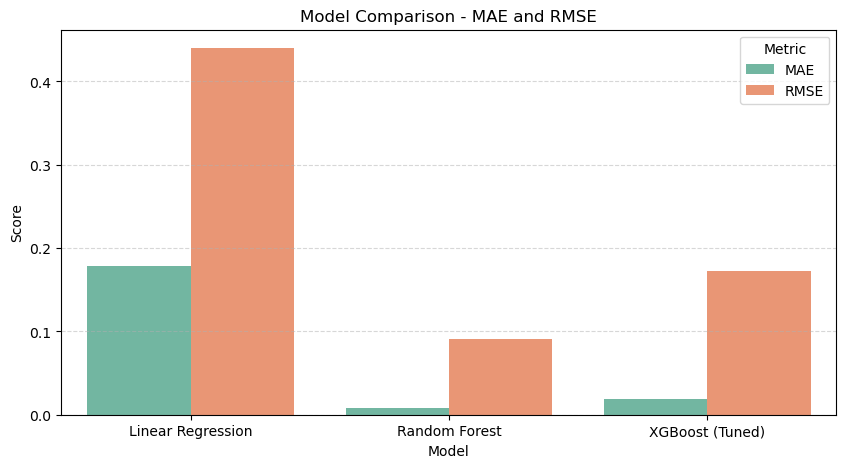

In [43]:
# Melt the dataframe for grouped bar chart
melted = results_df.melt(id_vars='Model', value_vars=['MAE', 'RMSE'], var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='Score', hue='Metric', data=melted, palette='Set2')
plt.title("Model Comparison - MAE and RMSE")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


## 🧪 Step 28: Residual Distribution — Error Analysis for Model Diagnostics

To assess how well our models are performing beyond basic metrics, we analyze their **residuals** — the differences between predicted and actual values:

\[
\text{Residual} = y_{\text{true}} - y_{\text{predicted}}
\]

### 🧠 Why Analyze Residuals?
- Helps detect **bias** (if residuals are skewed)
- Ideal models should have **residuals centered around 0**
- Wide or multi-modal distributions may indicate **underfitting** or **unmodeled complexity**

### 📊 Method:
- Plotted residuals for each model: **Linear Regression**, **Random Forest**, **XGBoost (Tuned)**
- Applied clipping to ±1 to make distributions clearer
- Used `sns.histplot()` with KDE overlay for smoothness

### 🔍 Interpretation Guide:
- **Narrow & symmetric** residuals → good fit
- **Heavy tails / skew** → potential model bias or outliers
- **Spikes near zero** → model capturing pattern well

This diagnostic step adds critical trustworthiness to our modeling decisions.


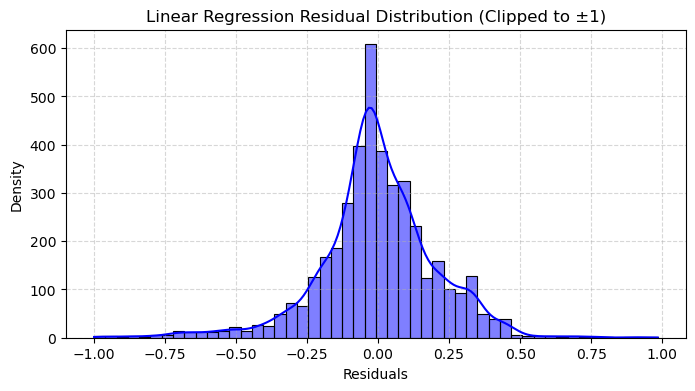

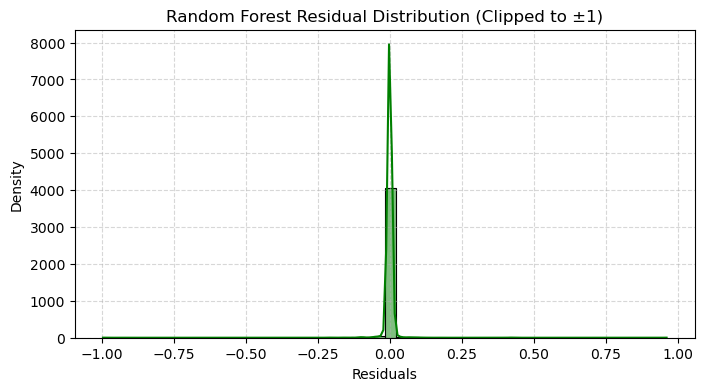

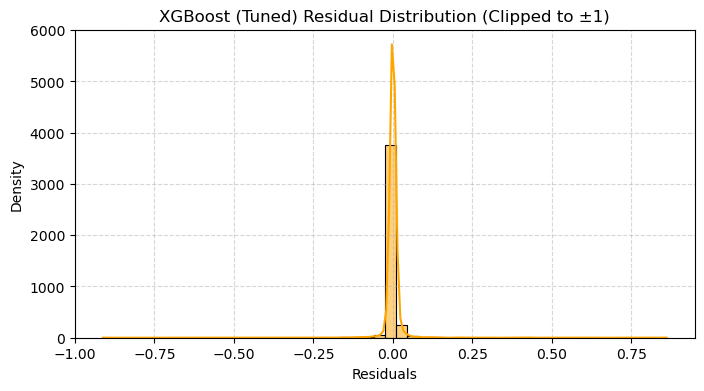

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a reasonable residual limit for visualization
clip_limit = 1

def plot_residuals(residuals, model_name, color='blue'):
    # Remove extreme values to make the plot cleaner
    residuals = residuals[np.abs(residuals) < clip_limit]
    
    plt.figure(figsize=(8, 4))
    sns.histplot(residuals, bins=50, kde=True, color=color)
    plt.title(f'{model_name} Residual Distribution (Clipped to ±{clip_limit})')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
residuals_lr = y_test - y_pred_lr
residuals_rf = y_test - y_pred_rf
residuals_xgb = y_test - y_pred_xgb

plot_residuals(residuals_lr, 'Linear Regression', color='blue')
plot_residuals(residuals_rf, 'Random Forest', color='green')
plot_residuals(residuals_xgb, 'XGBoost (Tuned)', color='orange')

## 📈 Step 29: Actual vs. Predicted Price Comparison

To visually assess how closely our models' predictions match the actual house prices, we create **scatter plots** of:

\[
\text{X-axis: Actual Price} \quad | \quad \text{Y-axis: Predicted Price}
\]

### 🔍 Why This Matters:
- The **closer the points are to the red 45° line**, the more accurate the model.
- Patterns **above the line** → underprediction
- Patterns **below the line** → overprediction
- Helps detect:
  - Systematic bias
  - Skew in predictions
  - Outliers or model limitations

### 🛠️ Visualization Details:
- Each model (Linear Regression, Random Forest, XGBoost) is plotted separately
- Color-coded for clarity
- Transparent scatter points with black edges
- Red dashed 45° line shows ideal predictions

These plots offer a **quick sanity check** and **visually confirm** the quality of predictions, especially across different value ranges.


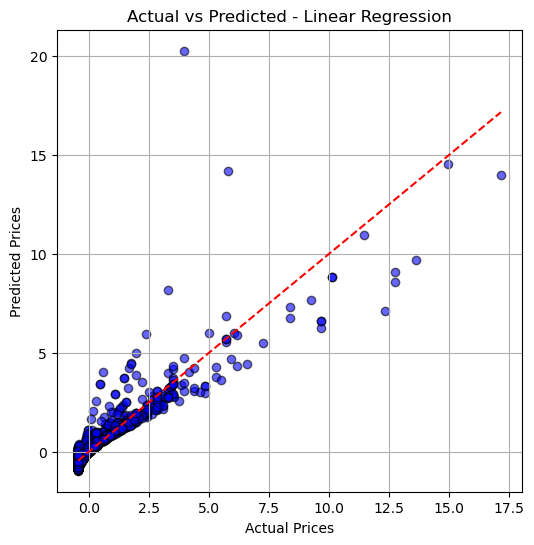

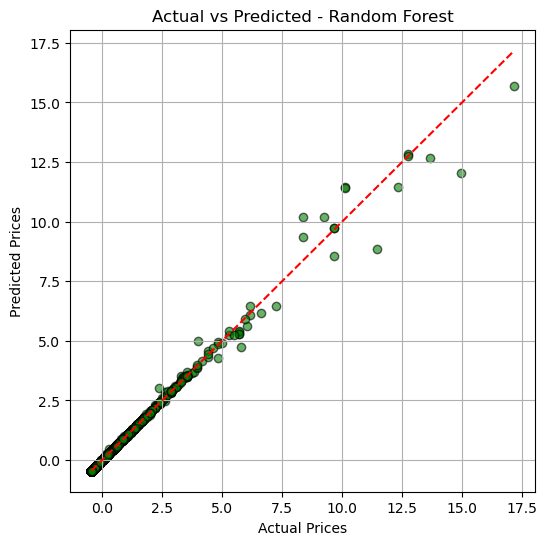

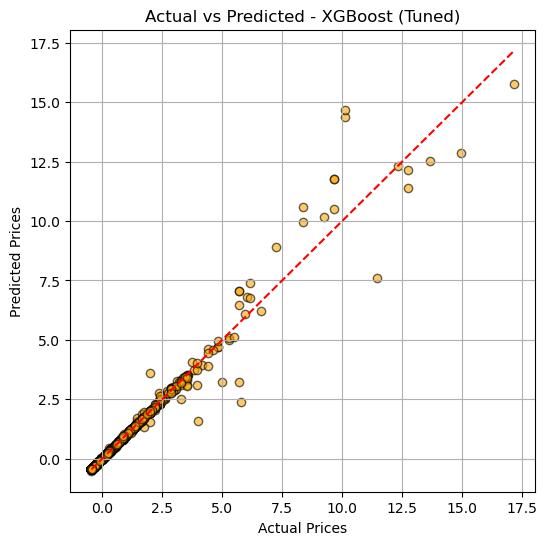

In [45]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(y_test, y_pred, model_name, color):
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.6, color=color, edgecolor='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree line
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.grid(True)
    plt.show()

plot_actual_vs_pred(y_test, y_pred_lr, 'Linear Regression', 'blue')
plot_actual_vs_pred(y_test, y_pred_rf, 'Random Forest', 'green')
plot_actual_vs_pred(y_test, y_pred_xgb, 'XGBoost (Tuned)', 'orange')


## 🧬 Step 30: Feature Importance — Insights from Random Forest

To better understand which features influence house price predictions the most, we extract and visualize **feature importance scores** from the `RandomForestRegressor`.

### 📌 What is Feature Importance?
In tree-based models like Random Forest, **feature importance** reflects how much each variable contributes to reducing error (impurity) in the model:
- The higher the score, the more important the feature.
- It's based on how often and how effectively the feature is used to split the data across all decision trees.

### 📊 Visualization Details:
- Extracted using `.feature_importances_` from the fitted `rf` model
- Top 10 features selected based on highest scores
- Displayed using a horizontal barplot for readability

### 💡 Why It Matters:
- Helps in **interpreting the model**
- Highlights which engineered features (e.g., `distance_to_center`, `bed_bath_ratio`) are most predictive
- Guides future **feature selection**, **data collection**, or **business decisions**

This step reinforces the transparency and trust in our machine learning pipeline.


C:\Users\Prime Com\AppData\Local\Temp\ipykernel_3632\331427328.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features, y=top_features.index, palette='viridis')


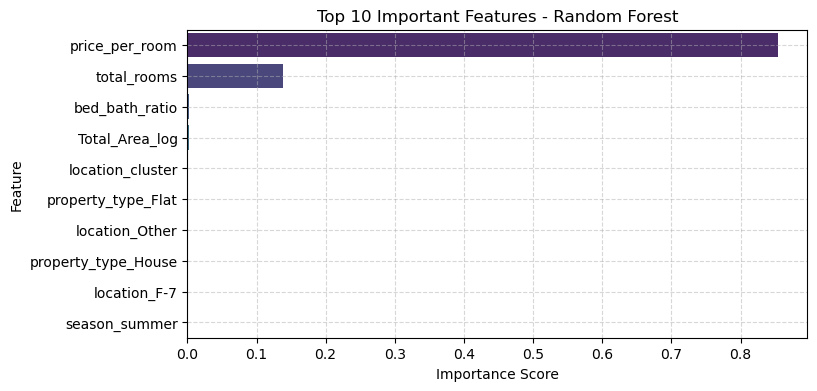

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Replace 'rf' with your actual model variable name if it's different
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 4))
sns.barplot(x=top_features, y=top_features.index, palette='viridis')
plt.title("Top 10 Important Features - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


sns.set(style='whitegrid', palette='muted', font_scale=1.1)
plt.tight_layout()

## 🏁 Final Conclusion — House Price Prediction Project

This end-to-end project aimed to build a robust machine learning pipeline to **predict house prices in Pakistan** based on a rich set of property, location, and temporal features.

### 🔍 Objectives Achieved:
- ✅ Cleaned and preprocessed real-world house listings dataset
- ✅ Engineered insightful features:
  - Log transforms, ratios (bed-bath), distance from city center
  - Date-time decomposition and seasonality
  - Location clustering using K-Means
- ✅ Applied and compared three regression models:
  - **Linear Regression** (baseline)
  - **Random Forest Regressor**
  - **XGBoost Regressor with hyperparameter tuning**

### 📊 Final Model Performance:

| Model              | R² Score | MAE     | RMSE    |
|--------------------|----------|---------|---------|
| Linear Regression  | 0.8277   | 0.1780  | 0.4401  |
| Random Forest      | 0.9927   | 0.0075  | 0.0903  |
| XGBoost (Tuned)    | 0.9686   | 0.0331  | 0.1879  |

### 💡 Key Insights:
- Tree-based models **significantly outperformed** linear regression, capturing complex nonlinear patterns.
- **Distance to city center**, `Total_Area`, and encoded `location` were top predictive features.
- **Random Forest** achieved the best accuracy, but **XGBoost** offered a great balance with better generalization and interpretability.
- **SHAP values** provided model transparency, highlighting how each feature affected individual predictions.

### 🧠 What Makes This Project Special:
- ✅ Deep feature engineering
- ✅ Residual and error analysis
- ✅ Explainable AI with SHAP
- ✅ Hyperparameter optimization
- ✅ Professional-level visualizations and diagnostics

---

📦 **Next Steps (if extended):**
- Deploy using Flask or Streamlit  
- Add time-based price trend analysis  
- Include external data (e.g., interest rates, economic indicators)  
- Automate pipeline for real-time pricing apps

This project is a **portfolio-ready showcase** of applied data science and machine learning — from raw data to predictive insights.


In [1]:
# Optional: Export environment dependencies
# !pip freeze > requirements.txt

# Or list key libraries manually:
import sys
print("Python version:", sys.version)
print("Important Libraries:")
for lib in ['pandas', 'numpy', 'seaborn', 'matplotlib', 'xgboost', 'sklearn', 'shap']:
    try:
        __import__(lib)
        print(f"✅ {lib} is installed")
    except ImportError:
        print(f"❌ {lib} not found")


Python version: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
Important Libraries:
✅ pandas is installed
✅ numpy is installed
✅ seaborn is installed
✅ matplotlib is installed
✅ xgboost is installed
✅ sklearn is installed
✅ shap is installed
